In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import ndcg_score

# === Load dataset ===
df = pd.read_csv("criteo_fairness_dataset_2024-01-01_2024-05-20.csv")
print("Columns in dataset:", df.columns.tolist())

# Define columns
target_col = "click"                 # relevance label (0/1)
protected_col = "protected_attribute"  # fairness group

# === Train/test split ===
train, test = train_test_split(
    df, test_size=0.2, stratify=df[protected_col], random_state=42
)

X_train = train.drop(columns=[target_col, protected_col])
y_train = train[target_col]
groups_train = train[protected_col]

X_test = test.drop(columns=[target_col, protected_col])
y_test = test[target_col]
groups_test = test[protected_col]

# === Train Bayesian model (with uncertainty) ===
model = BayesianRidge()
model.fit(X_train, y_train)

pred_mean, pred_std = model.predict(X_test, return_std=True)

# === Ranking based on predicted mean (higher = more likely to click) ===
ranked_indices = np.argsort(-pred_mean)
ranked_groups = groups_test.values[ranked_indices]

# Utility: NDCG (non-negative labels now: click ∈ {0,1})
ndcg = ndcg_score([y_test.values], [pred_mean])
print("NDCG:", ndcg)

# Fairness metric: group exposure (average ranking position)
positions = np.arange(1, len(ranked_indices) + 1)
df_ranked = pd.DataFrame({"group": ranked_groups, "position": positions})
exposure = df_ranked.groupby("group")["position"].mean().to_dict()
print("Exposure by group:", exposure)

# === Uncertainty-aware adjustment ===
uncertainty_threshold = np.percentile(pred_std, 75)  # top 25% most uncertain
adjusted_means = pred_mean.copy()
adjusted_means[pred_std > uncertainty_threshold] *= 0.9  # down-weight uncertain

# Re-rank
adjusted_ranked = np.argsort(-adjusted_means)
ndcg2 = ndcg_score([y_test.values], [adjusted_means])
print("Adjusted NDCG:", ndcg2)

df_adj = pd.DataFrame({
    "group": groups_test.values[adjusted_ranked],
    "position": np.arange(1, len(adjusted_ranked) + 1)
})
exposure_adj = df_adj.groupby("group")["position"].mean().to_dict()
print("Adjusted exposure:", exposure_adj)


Columns in dataset: ['click', 'protected_attribute', 'senior', 'displayrandom', 'rank', 'user_id', 'impression_id', 'product_id', 'cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'num16', 'num17', 'num18', 'num19', 'num20', 'num21', 'num22', 'num23', 'num24', 'num25', 'num26', 'num27', 'num28', 'num29', 'num30', 'num31', 'num32', 'num33', 'num34', 'num35', 'num36', 'num37', 'num38', 'num39', 'num40', 'num41', 'num42', 'num43', 'num44', 'num45', 'num46', 'num47', 'num48', 'num49', 'num50']
NDCG: 0.6244086704444547
Exposure by group: {0: 105144.42344459677, 1: 109302.57655540323}
Adjusted NDCG: 0.6252967347832951
Adjusted exposure: {0: 105081.00152952259, 1: 109365.99847047741}


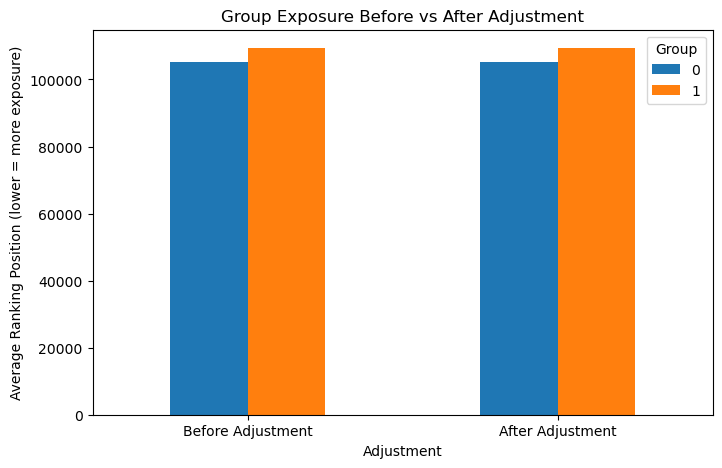

In [17]:
import matplotlib.pyplot as plt

# Combine exposure results
exposure_df = pd.DataFrame({
    "Before Adjustment": exposure,
    "After Adjustment": exposure_adj
})

# Plot
exposure_df.T.plot(kind="bar", figsize=(8, 5))
plt.title("Group Exposure Before vs After Adjustment")
plt.ylabel("Average Ranking Position (lower = more exposure)")
plt.xlabel("Adjustment")
plt.xticks(rotation=0)
plt.legend(title="Group")
plt.show()



In [ ]:
z